### Learning Curves for Kinecture Data
Can we expect accuracy to improve if we add more training data? Let's find out by generating learning curves.

First, we import modules and set up our datasets.

In [31]:
from sklearn import cross_validation
from sklearn.svm import LinearSVC
from sklearn.learning_curve import learning_curve

import pandas as pd
import seaborn as sns
sns.set(style="ticks", color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

from kinecture import speakerxy_experiment, ml_helper, plot_helper

# When we make changes to modules, automatically reload the modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
xls = pd.ExcelFile('data/allData-filtered.xlsx')
dataframe = xls.parse('filtered-noFormulas')
test09_dataframe = xls.parse('09test')
test10_dataframe = xls.parse('10test')
test11_dataframe = xls.parse('11test')

print("number of train instances:", len(dataframe))
print("test09 instances:", len(test09_dataframe))
print("test10 instances:", len(test10_dataframe))
print("test11 instances:", len(test11_dataframe))

number of train instances: 8906
test09 instances: 1108
test10 instances: 1068
test11 instances: 1149


In [25]:
dataframe = ml_helper.clean_data(dataframe)
test09_dataframe = ml_helper.clean_data(test09_dataframe)
test10_dataframe = ml_helper.clean_data(test10_dataframe)
test11_dataframe = ml_helper.clean_data(test11_dataframe)

In [26]:
dataframe = ml_helper.gen_features(dataframe)
test09_features = ml_helper.gen_features(test09_dataframe)
test10_features = ml_helper.gen_features(test10_dataframe)
test11_features = ml_helper.gen_features(test11_dataframe)

test09_features['Truth'] = ml_helper.remap_labels({"SI-FIX": "SI"}, 
                                                 test09_features['Truth'])
test10_features['Truth'] = ml_helper.remap_labels({"SI-FIX": "SI"}, 
                                                 test10_features['Truth'])
test11_features['Truth'] = ml_helper.remap_labels({"SI-FIX": "SI"}, 
                                                 test11_features['Truth'])

In [28]:
test09_sklearn = ml_helper.convert_features_for_sklearn(test09_features)
test10_sklearn = ml_helper.convert_features_for_sklearn(test10_features)
test11_sklearn = ml_helper.convert_features_for_sklearn(test11_features)
train_sklearn = ml_helper.convert_features_for_sklearn(dataframe)

train_test_combined_sklearn = train_sklearn.append(test09_sklearn).append(test10_sklearn).append(test11_sklearn)

The below code is used to generate and plot a learning curve, and is taking from a tutorial on scikit-learn's website.

In [29]:
# Following code gratefully borrowed from 
# http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



### Learning Curve Using Linear SVM, Cross validate on training data
For each train size, evaluate accuracy using cross validation, randomly removing 20% of train data. Repeat 100 times.

Use training data only when performing cross validation, test data ignored.

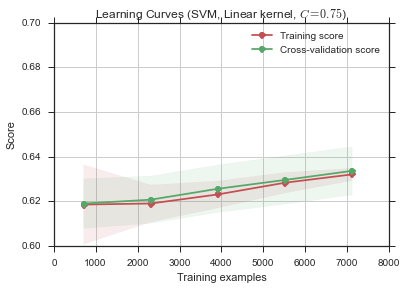

In [32]:
X, y = train_sklearn.X, train_sklearn.y

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

title = "Learning Curves (SVM, Linear kernel, $C=0.75$)"
# SVC is more expensive so we do a lower number of CV iterations:
estimator = LinearSVC(C=0.75)
plot_learning_curve(estimator, title, X, y, (0.6, 0.7), cv=cv, n_jobs=4)

plt.show()

Accuracy seems to be increasing with more datapoints, however two things are suspicious here:

1. Cross validation accuracy is equal to or higher than training accuracy. This suggests that the test sets used in cross validation are very similar to train sets. Here the test sets may be temporally close to train sets, so test data is very similar to train data.
2. Accuracy numbers are about 10% higher than observed on train test split in `02-machine_learning` notebook. Again, suggests test data is very similar to train data.

To fix this, we can add in the test data when performing cross validation for the learning curve.

### Learning Curve Using Linear SVM, Cross validate on train & test sets combined
Same as above except the cross validation adds test data in as well.

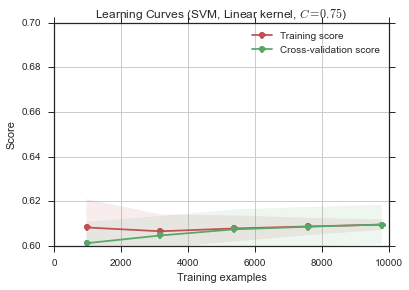

In [33]:
X, y = train_test_combined_sklearn.X, train_test_combined_sklearn.y

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

title = "Learning Curves (SVM, Linear kernel, $C=0.75$)"
# SVC is more expensive so we do a lower number of CV iterations:
estimator = LinearSVC(C=0.75)
plot_learning_curve(estimator, title, X, y, (0.6, 0.7), cv=cv, n_jobs=4)

plt.show()

This curve looks closer to what we expect, and accuracy is closer to what we observed in `02-machine_learning` (though still a little too high). Accuracy seems to top out at 61% for a linear kernel.

We can also try a non-linear kernel, again using the dataset where train and test data are combined to avoid unusually high results.

In [ ]:
X, y = train_test_combined_sklearn.X, train_test_combined_sklearn.y

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

title = "Learning Curves (SVM, RBF, $C=0.1 \gamma=10$)"
# SVC is more expensive so we do a lower number of CV iterations:
estimator = SVC(C=0.75, gamma=10)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)


plt.show()

For the RBF kernel we see that the curve increases as the number of samples increases. This is encouraging, but again we should be wary, since it is unusual for the training score and cross-validation scores to be so similar. We should verify by ensuring that training and testing samples are separated in time, or in session.

### Linear SVM Using Leave One Session Out Cross Validation

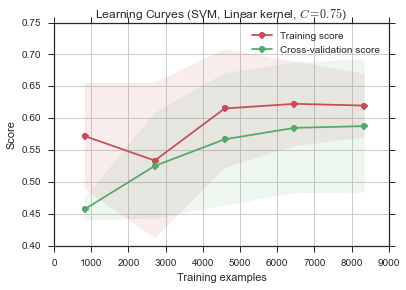

In [44]:
X, y = train_test_combined_sklearn.X, train_test_combined_sklearn.y

# which index is the session?
train_test_session_labels = np.concatenate([dataframe.session, test09_dataframe.session, test10_dataframe.session, test11_dataframe.session])

cv = cross_validation.LeaveOneLabelOut(train_test_session_labels)

title = "Learning Curves (SVM, Linear kernel, $C=0.75$)"
# SVC is more expensive so we do a lower number of CV iterations:
estimator = LinearSVC(C=0.75)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

plt.show()

Cross validation across sessions we get a cross validation accuracy close to what we got when having a separate test dataset (peaks at around 58%). Furthermore, we see the curve flattening out. Train and test error don't exaclty match either, suggesting some overfitting. Reducing number of features may improve accuracy a little, however to get significant improvements better features are needed.

### Leave One Session Out Cross-Validation with Noninear kernel

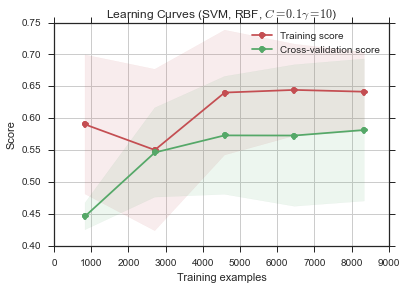

In [46]:
X, y = train_test_combined_sklearn.X, train_test_combined_sklearn.y


# which index is the session?
train_test_session_labels = np.concatenate([dataframe.session, test09_dataframe.session, test10_dataframe.session, test11_dataframe.session])
cv = cross_validation.LeaveOneLabelOut(train_test_session_labels)

title = "Learning Curves (SVM, RBF, $C=0.1 \gamma=10$)"
# SVC is more expensive so we do a lower number of CV iterations:
estimator = SVC(C=0.75, gamma=10)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)


plt.show()

With a nonlinear kernel we see a similar flattening out of accuracy as with a linear kernel. Cross-validation accuracy is similar to the linear kernel, at just below 60%. However, train accuracy is several percentage points higher, suggesting that the nonlinear kernel overfits more than the linear kernel. This is not surprising. A nonlinear kernel doesn't seem to be helping us much here.

### Conclusion
When generating a learning curve, it is important to ensure that train and test datasets are not too close temporally, otherwise accuracies are inflated. I therefore performed cross validation by leaving one session out (training on the other two), and generated a learning curve. When generating a learning curve using leave-one-session-out cross validation I noticed two things: (1) there is a gap between the train accuracy and cross validation accuracy, and (2) cross validation accuracy does not seem to increase beyond 6000 instances. From this, I draw two conclusions (1) accuracy may be improved by reducing the number of features, and (2) I don't expect accuracy to increase much by adding more training data. Finally, better features or a different approach are necessary to reach recall exceeding 65%, as recall on the train dataset is capped by this.

Suggestions for next steps are:

1. Extract frequency domain features from audio clips.
2. Train a hidden markov model or similar rather than performing classification.